# ***IMPORTS***

In [1]:
%%capture
!pip install -U "tensorflow-text==2.15.*"
!pip install "tf-models-official==2.15.*"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re, string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')
import pickle


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# ***LOADING DATASET & PLOTTING***

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
OVS = pd.read_csv('/content/drive/MyDrive/496/OVS.csv')
metasploitable = pd.read_csv('/content/drive/MyDrive/496/metasploitable-2.csv')
Normal_data = pd.read_csv('/content/drive/MyDrive/496/Dataset/Normal_data.csv')


In [8]:
combined_data = pd.concat([OVS, metasploitable, Normal_data], ignore_index=True)
combined_data.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,4045,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
1,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,284,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
2,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,4302,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
3,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,83,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,172.17.0.2-200.175.2.130-80-48860-6,200.175.2.130,48860,172.17.0.2,80,6,12/1/2020 1:14,3760,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [9]:
non_numeric_columns = combined_data.select_dtypes(exclude=['int', 'float', 'bool']).columns
combined_data = combined_data.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'])
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(combined_data['Label'])
previous_values = label_encoder.classes_
print(previous_values)

# Splitting the data into train and test sets
X = combined_data.drop(columns=['Label'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2)

['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']


In [10]:
combined_data.info()
combined_data.to_csv('/content/combined_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src Port           343889 non-null  int64  
 1   Dst Port           343889 non-null  int64  
 2   Protocol           343889 non-null  int64  
 3   Flow Duration      343889 non-null  int64  
 4   Tot Fwd Pkts       343889 non-null  int64  
 5   Tot Bwd Pkts       343889 non-null  int64  
 6   TotLen Fwd Pkts    343889 non-null  float64
 7   TotLen Bwd Pkts    343889 non-null  float64
 8   Fwd Pkt Len Max    343889 non-null  int64  
 9   Fwd Pkt Len Min    343889 non-null  int64  
 10  Fwd Pkt Len Mean   343889 non-null  float64
 11  Fwd Pkt Len Std    343889 non-null  float64
 12  Bwd Pkt Len Max    343889 non-null  int64  
 13  Bwd Pkt Len Min    343889 non-null  int64  
 14  Bwd Pkt Len Mean   343889 non-null  float64
 15  Bwd Pkt Len Std    343889 non-null  float64
 16  Fl

# ***MODEL TRAINING***

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import compute_sample_weight

# Define the XGBoost model
device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
params = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'min_child_weight': 3}
xgb_model = xgb.XGBClassifier(**params, tree_method='auto', device=device, objective='multi:softmax', num_class=len(np.unique(Y_train)),)
# Train the model
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)
xgb_model.fit(X_train, Y_train, sample_weight=sample_weights)
with open("/content/drive/MyDrive/496/Trained/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
# Predictions on the test set
xgb_prediction = xgb_model.predict(X_test)
prev = ['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']
# Generate classification report
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(xgb_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         BFA       1.00      1.00      1.00       273
      BOTNET       1.00      1.00      1.00        32
        DDoS       1.00      0.99      0.99     15044
       DDoS        0.98      1.00      0.99      9531
         DoS       1.00      1.00      1.00     10751
      Normal       1.00      1.00      1.00     13462
       Probe       1.00      1.00      1.00     19644
  Web-Attack       1.00      1.00      1.00        41

    accuracy                           1.00     68778
   macro avg       1.00      1.00      1.00     68778
weighted avg       1.00      1.00      1.00     68778

Accuracy: 0.9972374887318619


In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=100)
logistic_model.fit(X_train, Y_train)
with open("/content/drive/MyDrive/496/Trained/logistic_model.pkl", "wb") as f:
    pickle.dump(logistic_model, f)
logistic_prediction = logistic_model.predict(X_test)
prev = ['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(logistic_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

              precision    recall  f1-score   support

         BFA       0.00      0.00      0.00         0
      BOTNET       0.00      0.00      0.00         0
        DDoS       0.01      0.93      0.03       231
       DDoS        1.00      0.34      0.51     28102
         DoS       0.13      0.43      0.20      3312
      Normal       0.93      0.62      0.74     20177
       Probe       0.65      0.75      0.70     16956
  Web-Attack       0.00      0.00      0.00         0

    accuracy                           0.53     68778
   macro avg       0.34      0.38      0.27     68778
weighted avg       0.85      0.53      0.61     68778

Accuracy: 0.5309692052691267


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.naive_bayes import GaussianNB
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, Y_train)
with open("/content/drive/MyDrive/496/Trained/naive_bayes_model.pkl", "wb") as f:
    pickle.dump(naive_bayes_model, f)
nv_prediction = naive_bayes_model.predict(X_test)
prev = ['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(nv_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         BFA       0.72      0.02      0.03     10976
      BOTNET       1.00      0.00      0.00     17988
        DDoS       0.00      0.01      0.00       196
       DDoS        1.00      0.40      0.57     24288
         DoS       0.07      0.78      0.14      1023
      Normal       0.31      0.92      0.46      4502
       Probe       0.32      0.98      0.48      6310
         U2R       0.00      0.00      0.00        96
  Web-Attack       0.00      0.00      0.00      3399

    accuracy                           0.31     68778
   macro avg       0.38      0.35      0.19     68778
weighted avg       0.78      0.31      0.28     68778



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=10)
random_forest_model.fit(X_train, Y_train)
with open("/content/drive/MyDrive/496/Trained/random_forest_model.pkl", "wb") as f:
    pickle.dump(random_forest_model, f)
random_forest_pred = random_forest_model.predict(X_test)
prev = ['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(random_forest_pred)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print(accuracy  )

              precision    recall  f1-score   support

         BFA       0.82      0.98      0.89       250
      BOTNET       1.00      1.00      1.00        33
        DDoS       1.00      0.99      0.99     14815
       DDoS        0.98      1.00      0.99      9577
         DoS       1.00      1.00      1.00     10710
      Normal       1.00      1.00      1.00     13648
       Probe       1.00      1.00      1.00     19706
         U2R       0.75      1.00      0.86         3
  Web-Attack       0.90      1.00      0.95        36

    accuracy                           1.00     68778
   macro avg       0.94      1.00      0.96     68778
weighted avg       1.00      1.00      1.00     68778

0.9964814330163715


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, Y_train)
with open("/content/drive/MyDrive/496/Trained/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)
knn_model_pred = knn_model.predict(X_test)
prev = ['BFA' 'BOTNET' 'DDoS' 'DDoS ' 'DoS' 'Normal' 'Probe' 'U2R' 'Web-Attack']
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(knn_model_pred)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)

              precision    recall  f1-score   support

         BFA       0.97      0.94      0.96       285
      BOTNET       1.00      1.00      1.00        32
        DDoS       1.00      0.99      0.99     15071
       DDoS        0.98      1.00      0.99      9506
         DoS       0.99      0.99      0.99     10762
      Normal       0.99      0.99      0.99     13444
       Probe       1.00      1.00      1.00     19648
  Web-Attack       0.66      0.90      0.76        30

    accuracy                           0.99     68778
   macro avg       0.95      0.98      0.96     68778
weighted avg       0.99      0.99      0.99     68778



# ***EDA***

In [ ]:
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Open the XGBoost model from the drive
with open("/content/drive/MyDrive/496/Trained/xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

# Predictions on the test set
xgb_prediction = xgb_model.predict(X_test)

# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(xgb_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)

# Calculate accuracy
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(label_encoder.inverse_transform(Y_test), decoded_predictions)

# Save results as a dictionary
xgb_model_results = {
    'accuracy': accuracy,
    'classification_report': report,
    'confusion_matrix': conf_matrix
}




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:13:15] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:13:15] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         BFA       1.00      1.00      1.00       300
      BOTNET       1.00      1.00      1.00        33
        DDoS       1.00      0.99      0.99     14789
       DDoS        0.99      1.00      0.99      9603
         DoS       1.00      1.00      1.00     10702
      Normal       1.00      1.00      1.00     13649
       Probe       1.00      1.00      1.00     19658
         U2R       1.00      1.00      1.00         4
  Web-Attack       1.00      1.00      1.00        40

    accuracy                           1.00     68778
   macro avg       1.00      1.00      1.00     68778
weighted avg       1.00      1.00      1.00     68778

Accuracy: 0.997673674721568


In [ ]:
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Open the Logistic Regression model from the drive
with open("/content/drive/MyDrive/496/Trained/logistic_model.pkl", "rb") as f:
    logistic_model = pickle.load(f)

# Predictions on the test set
logistic_prediction = logistic_model.predict(X_test)

# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(logistic_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)

# Calculate accuracy
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(label_encoder.inverse_transform(Y_test), decoded_predictions)

# Save results as a dictionary
logistic_model_results = {
    'accuracy': accuracy,
    'classification_report': report,
    'confusion_matrix': conf_matrix
}



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         BFA       0.00      0.00      0.00         0
      BOTNET       0.00      0.00      0.00         0
        DDoS       0.01      0.90      0.03       235
       DDoS        1.00      0.35      0.52     27965
         DoS       0.13      0.42      0.19      3278
      Normal       0.93      0.62      0.75     20380
       Probe       0.65      0.75      0.69     16920
         U2R       0.00      0.00      0.00         0
  Web-Attack       0.00      0.00      0.00         0

    accuracy                           0.53     68778
   macro avg       0.30      0.34      0.24     68778
weighted avg       0.85      0.53      0.61     68778

Accuracy: 0.5337753351362354


In [ ]:
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Open the Naive Bayes model from the drive
with open("/content/drive/MyDrive/496/Trained/naive_bayes_model.pkl", "rb") as f:
    naive_bayes_model = pickle.load(f)

# Predictions on the test set
naive_bayes_prediction = naive_bayes_model.predict(X_test)

# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(naive_bayes_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)

# Calculate accuracy
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(label_encoder.inverse_transform(Y_test), decoded_predictions)

# Save results as a dictionary
naive_bayes_model_results = {
    'accuracy': accuracy,
    'classification_report': report,
    'confusion_matrix': conf_matrix
}




              precision    recall  f1-score   support

         BFA       0.69      0.02      0.04     11109
      BOTNET       1.00      0.00      0.00     17888
        DDoS       0.00      0.00      0.00       197
       DDoS        1.00      0.40      0.57     24117
         DoS       0.08      0.81      0.14      1031
      Normal       0.31      0.92      0.46      4611
       Probe       0.32      0.99      0.48      6388
         U2R       0.50      0.02      0.04       100
  Web-Attack       0.03      0.00      0.00      3337

    accuracy                           0.31     68778
   macro avg       0.44      0.35      0.19     68778
weighted avg       0.78      0.31      0.29     68778

Accuracy: 0.31025909447788536


In [ ]:
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Open the Random Forest model from the drive
with open("/content/drive/MyDrive/496/Trained/random_forest_model.pkl", "rb") as f:
    random_forest_model = pickle.load(f)

# Predictions on the test set
random_forest_prediction = random_forest_model.predict(X_test)

# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(random_forest_prediction)

# Generate classification report
report = classification_report(decoded_predictions, label_encoder.inverse_transform(Y_test))
print(report)

# Calculate accuracy
accuracy = accuracy_score(label_encoder.inverse_transform(Y_test), decoded_predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(label_encoder.inverse_transform(Y_test), decoded_predictions)

# Save results as a dictionary
random_forest_model_results = {
    'accuracy': accuracy,
    'classification_report': report,
    'confusion_matrix': conf_matrix
}



              precision    recall  f1-score   support

         BFA       0.82      0.98      0.89       250
      BOTNET       1.00      1.00      1.00        33
        DDoS       1.00      0.99      0.99     14815
       DDoS        0.98      1.00      0.99      9577
         DoS       1.00      1.00      1.00     10710
      Normal       1.00      1.00      1.00     13648
       Probe       1.00      1.00      1.00     19706
         U2R       0.75      1.00      0.86         3
  Web-Attack       0.90      1.00      0.95        36

    accuracy                           1.00     68778
   macro avg       0.94      1.00      0.96     68778
weighted avg       1.00      1.00      1.00     68778

Accuracy: 0.9964814330163715


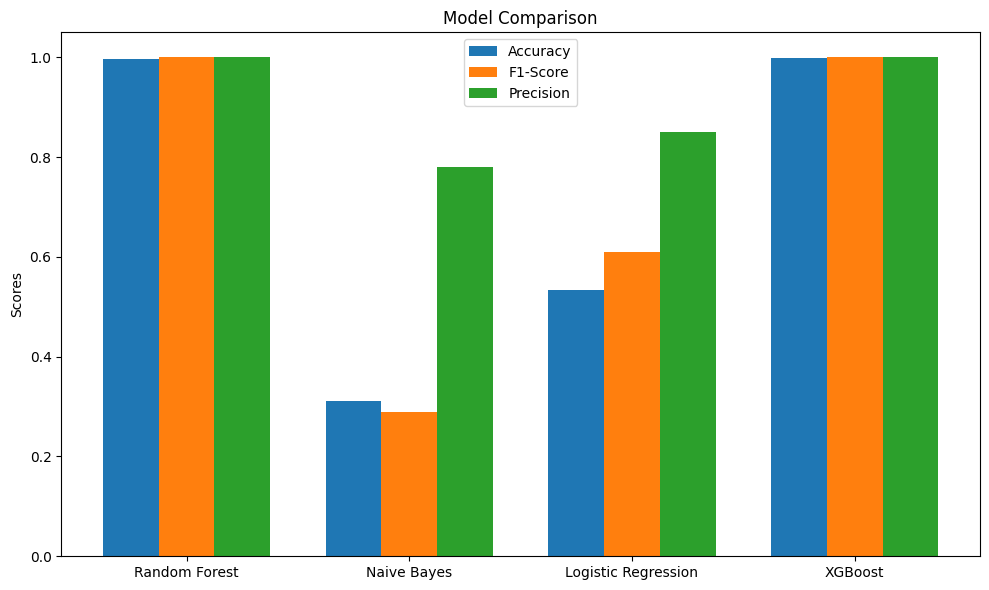

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy comparison
models = ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'XGBoost']
accuracies = [random_forest_model_results['accuracy'],
              naive_bayes_model_results['accuracy'],
              logistic_model_results['accuracy'],
              xgb_model_results['accuracy']]

# F1-score comparison
f1_scores = [float(random_forest_model_results['classification_report'].split()[-2]),
             float(naive_bayes_model_results['classification_report'].split()[-2]),
             float(logistic_model_results['classification_report'].split()[-2]),
             float(xgb_model_results['classification_report'].split()[-2])]

# Precision comparison
precisions = [float(random_forest_model_results['classification_report'].split()[-4]),
              float(naive_bayes_model_results['classification_report'].split()[-4]),
              float(logistic_model_results['classification_report'].split()[-4]),
              float(xgb_model_results['classification_report'].split()[-4])]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x, f1_scores, width, label='F1-Score')
rects3 = ax.bar(x + width, precisions, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()


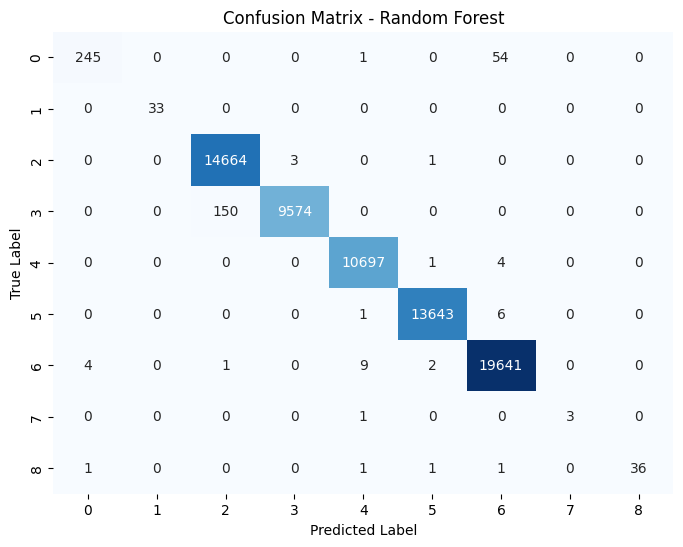

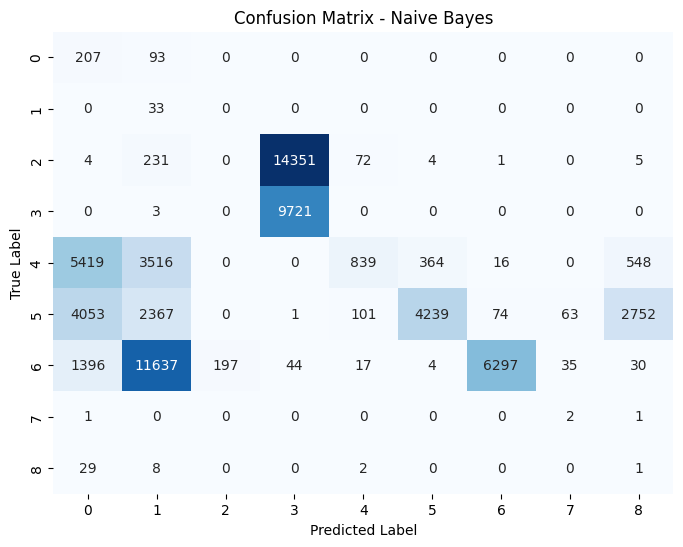

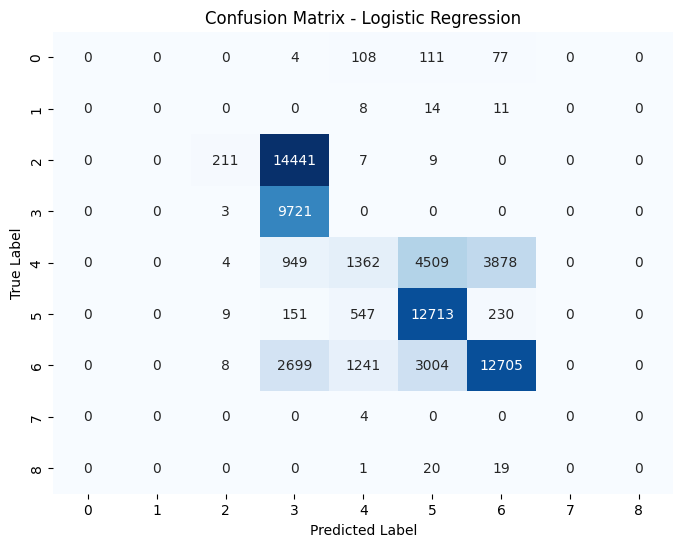

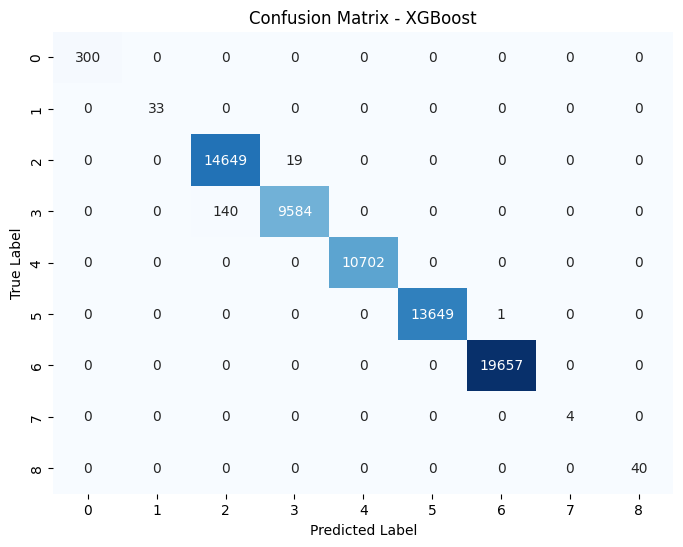

In [ ]:
confusion = [random_forest_model_results['confusion_matrix'], naive_bayes_model_results['confusion_matrix'], logistic_model_results['confusion_matrix'],
              xgb_model_results['confusion_matrix']]
models = ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'XGBoost']

for i, confusion_matrix in enumerate(confusion):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {models[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()